In [7]:
using Pkg
Pkg.activate("/home/mrind3v/code/scientific-ml/")
#Pkg.add(["JLD", "Lux", "DiffEqFlux","DifferentialEquations","ComponentArrays", "Optimization", "OptimizationOptimJL", "Random","Plots"])
using JLD
using Lux
using DiffEqFlux
using DifferentialEquations
using ComponentArrays
using Optimization
using OptimizationOptimJL
using Random
using Plots

  Activating project at `~/code/scientific-ml`
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


### Modeling Tumor Growth with a Gompertzian ODE

To simulate the tumor dynamics, we use a modified Gompertz model, which is a common Ordinary Differential Equation (ODE) for describing tumor growth. The model incorporates both natural growth and the effects of an anti-cancer intervention like chemotherapy.

The central equation is:
$$ \frac{dT}{dt} = r T \ln\left(\frac{K}{T}\right) - c(t)T $$

This equation describes the rate of change of the tumor size `T` over time `t`.

#### Components of the Model

The equation is composed of two main parts:
1.  **Gompertz Growth Term**: `r * T * ln(K/T)`
    *   This part of the equation models the natural growth of the tumor. The growth is fast when the tumor is small but slows down as it approaches its maximum sustainable size.
2.  **Chemotherapy Effect Term**: `c(t) * T`
    *   This term models the reduction in tumor size due to treatment. It represents a negative pressure on the tumor's growth.

Each variable in the equation has a specific biological meaning:
*   `T(t)`: Represents the size of the tumor at a given time `t`. This could be measured as volume (mm³), number of cells, or a normalized value.
*   `r`: The intrinsic **Tumor Growth Rate**. This parameter describes how quickly the tumor expands when it is small and has ample resources.
*   `K`: The **Carrying Capacity**. This is the maximum size the tumor can reach given the constraints of its environment, such as nutrient and oxygen supply.
*   `c(t)`: The **Chemotherapy-Induced Kill Rate**. This function represents the effectiveness of the chemotherapy treatment over time. In your code, this is modeled as `c*sigmoid(t/5)`, and it dynamically influences the treatment's impact.
    *   **Immediate Effect**: Because the `sigmoid(t/5)` function is 0.5 at `t=0`, the drug begins to cut the tumor's net growth rate right from the beginning. This ensures the tumor does not get any time to grow without opposition.
    *   **Increasing Potency**: As time `t` increases, the `sigmoid(t/5)` term grows from 0.5 towards its maximum value of 1. This models how the drug's **killing effect grows with time**, becoming progressively stronger during the initial phase of treatment before reaching its full, sustained potential.

### Role of the Neural Network

In many real-world biological systems, parameters like the growth rate (`r`) and the carrying capacity (`K`) are extremely difficult or impossible to measure directly for a specific patient's tumor.

This is where the Universal Differential Equation (UDE) approach comes in. Instead of using fixed, predetermined values for `r` and `K`, we will use a neural network to learn these parameters from the data. The neural network will predict the values of `r` and `K` that best fit the observed tumor growth data.

By embedding a neural network within the differential equation, we create a hybrid model that combines our knowledge of the system's structure (the Gompertz equation) with the flexibility of machine learning to uncover the unknown parameters.

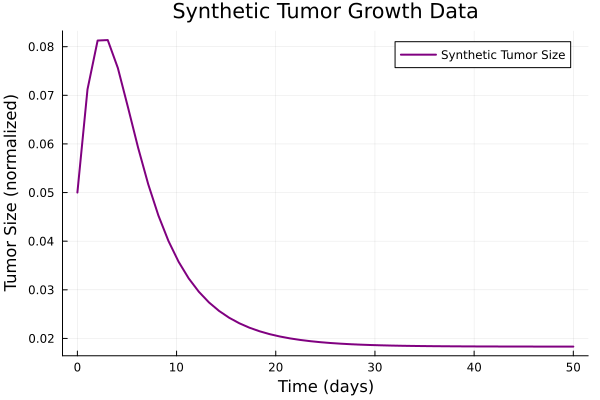

In [20]:
# 1. Generating synthetic data for the tumor growth model 

N_days = 50
const T0 = 0.05  # Initial tumor size (normalized)

# True parameters for synthetic data generation
p0 = [0.5, 1.0, 2]  # [r, K, c]  
# it must be an array because ODEProblem is defined to be in-place and u,u0 are required to be arrays
u0 = [T0] # you can directly pass [T0] as well in ODEProblem
tspan = (0.0, Float64(N_days)) # tuple of two numbers - start and end times
t = range(tspan[1], tspan[2], length=N_days) # range fn generates sequence of numbers. Basically, t is an array of time-points from 0 to 50

function tumor_growth_chemo!(du, u, p, t)
    T = max(u[1],0) # to make sure Tumor size is never -ve and it's always a zero or a +ve number (u)
    r, K, c = abs.(p)  # Ensure all parameters are positive
    du[1] = r * T * log(K / T) - c*sigmoid(t/5) * T # c*sigmoid(t/5) -> to make "c" depedentent on time 
end

prob = ODEProblem(tumor_growth_chemo!, u0, tspan, p0)
true_sol = Array(solve(prob, Tsit5(), saveat=t)) # [ T(t_1) T(t_2) T(t_3) ... T(t_50) ]

using Plots

plot(t, true_sol[1, :], # true_sol[1st row, all columns]
     label = "Synthetic Tumor Size",
     linewidth = 2,
     color = :purple)

xlabel!("Time (days)")
ylabel!("Tumor Size (normalized)")
title!("Synthetic Tumor Growth Data")


In [21]:
# 2. UDE model for tumor growth

rng = Random.default_rng() # random number generator 

# Neural networks for r(T) and K(T)
# we are creating two separate NNs for prediction of r and K terms. We could also do it using one single NN
NN_r = Lux.Chain(Lux.Dense(1, 10, relu), Lux.Dense(10, 1)) 
NN_K = Lux.Chain(Lux.Dense(1, 10, relu), Lux.Dense(10, 1))

p1, st1 = Lux.setup(rng, NN_r) # states (st1 and st2) are not important for us now. For simple dense layers, they are empty
p2, st2 = Lux.setup(rng, NN_K) # p1 and p2 are the initial set of parameters of NN randomised using rng

#= 
p0_vec:
(
  layer_r = (
      layer_1 = (weight = [0.1 -0.2], bias = [0.05])
  ),
  layer_k = (
      layer_1 = (weight = [0.3 0.4], bias = [-0.01])
  )
)

ComponentArray(p0_vec): (for the solver, now, the p0_vec looks like a simple vector )
ComponentVector{Float64}(
  layer_r = (
      layer_1 = (weight = [0.1 -0.2], bias = [0.05])
  ),
  layer_k = (
      layer_1 = (weight = [0.3 0.4], bias = [-0.01])
  )
)

=#

p0_vec = (layer_r = p1, layer_k = p2)
p0_vec = ComponentArray(p0_vec)

# softplus is to guarantee that the outputs of NN are always positive. Because NN output isn't bounded, it can be any real number 
# we didn't use abs() function instead, because it derivative of abs fn doesn't exist when the input is 0. Softplus is a smooth function 
# so the derivative won't be undefined at any point
function my_softplus(x)
    return log(1 + exp(x))
end


function tumor_UDE!(du, u, p, t)
    T = max(u[1],0)
    
    r_out, _ = NN_r([T], p.layer_r, st1)
    K_out, _ = NN_K([T], p.layer_k, st2)

    # clamp forces the output to be in a specific [min, max] range. Otherwise the simulation can become unstable, producing NaN or Inf
    r = clamp(my_softplus(r_out[1]), 1e-4, 1.0)
    K = clamp(my_softplus(K_out[1]), 0.01, 1.0)

    du[1] = r * T * log(K / T) - p0[3]*sigmoid(t/5) * T  
end

ude_prob = ODEProblem(tumor_UDE!, u0, tspan, p0_vec)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 50.0)
u0: 1-element Vector{Float64}:
 0.05

### Defining and Calculating the Loss

The **loss function** is the most important part of the training process. Its job is to quantify how "wrong" our model's current prediction is compared to the actual data. The optimizer's goal is to adjust the neural network's parameters to make the value returned by this function as low as possible.

Our loss function, `loss_function(p)`, takes one argument: `p`, which represents the current set of **weights and biases** for our neural networks (`NN_r` and `NN_K`).

#### Inside the Function

1.  **Solving the UDE**: The first step inside the function is to solve our UDE using the current parameters `p`:
    ```julia
    sol = solve(ude_prob, Tsit5(), u0=u0, p=p, saveat=t, sensealg=QuadratureAdjoint())
    ```
    This line generates a new prediction of tumor growth based on the `r` and `K` values produced by the neural networks with their current weights `p`.

2.  **The `sol` Object**: The output, `sol`, is not a simple array but a rich `ODESolution` object. Think of it as a detailed report of the simulation. It contains:
    *   `sol.u`: The actual solution values (the tumor size `T` at each time point).
    *   `sol.t`: The time points at which the solution was saved.
    *   Other metadata like the return code (`retcode`), which tells us if the solver succeeded or failed.
    Even though it's a complex object, it's designed to be accessed conveniently. The expression `sol[1, :]` is a special shortcut that extracts the values for the first variable (tumor size) at all time points and returns them as a simple vector, ready for comparison.

3.  **The Safety Check**: The following `if` block is a crucial piece of defensive programming that makes our training robust:
    ```julia
    if any(x -> any(isnan, x), sol.u) || length(sol.t) != length(t)
        return Inf
    end
    ```
    This code handles cases where the neural network suggests parameters `p` that are so unrealistic that the ODE solver fails. It checks for two failure modes:
    *   **`any(x -> any(isnan, x), sol.u)`**: This asks, "Are there any `NaN` (Not a Number) values in our solution?" This can happen if the parameters lead to an impossible mathematical operation, like `log()` of a negative number, causing the simulation to break.
    *   **`length(sol.t) != length(t)`**: This asks, "Did the solver finish the full 50-day simulation?" Sometimes, the parameters make the equation too "stiff" or unstable for the solver to handle, and it gives up partway through. In this case, it would return a partial solution with fewer than the 50 time points we requested.

    If either of these conditions is true, it means we have a failed solution that cannot be compared to our ground truth. We `return Inf` (infinity) to send a powerful penalty signal to the optimizer.

4.  **Calculating the Loss**: If the safety check passes, we calculate the loss:
    ```julia
    return sum(abs2, sol[1, :] .- true_sol[1, :])
    ```
    This calculates the **sum of squared errors** (also known as the L2 loss). It subtracts the predicted tumor sizes from the true (synthetic) ones, squares the differences at each time point to make them positive, and adds them all up. The result is a single number that represents the total error of the prediction.


### The Optimization Cycle

This loss function is the engine of an iterative training loop run by an optimizer (e.g., Adam). Here is how the cycle works:
1.  The optimizer starts with an initial guess for the neural networks' **weights and biases (`p`)**.
2.  It calls the `loss_function(p)` with these parameters.
3.  The function solves the UDE and calculates a loss value. If the solver fails, the loss is `Inf`, and the optimizer knows it made a bad choice.
4.  The optimizer uses the calculated loss (and its gradient) to make an intelligent decision about how to **update the weights and biases (`p`)**. The goal is to choose new values for `p` that are likely to produce a lower loss in the next step.
5.  This process **repeats for many iterations**. In each iteration, the optimizer provides a new set of weights and biases, which in turn produce new `r` and `K` values, leading to a new predicted tumor size curve and a new loss value.
6.  Over time, the optimizer finds the specific weights and biases that cause the neural networks to predict `r` and `K` values that result in a tumor growth curve that is as close as possible to the `true_sol`, thereby minimizing the loss and successfully training our model.

In [22]:
# 3. Defining the Loss Function
function loss_function(p)
    sol = solve(ude_prob, Tsit5(), u0=u0, p=p, saveat=t, sensealg=QuadratureAdjoint())

    if any(x -> any(isnan, x), sol.u) || length(sol.t) != length(t)
        # making the loss infinity, to adjust the weights & biases such that are no bad values (Tumor Size due to bad r and K,
        # which in turn is due to bad weights and biases)
        return Inf
    end

    return sum(abs2, sol[1, :] .- true_sol[1, :])
end

loss_function (generic function with 1 method)

### Training the Model with a Powerful Optimizer

This cell executes the core training process. We take the `loss_function` we defined, package it into a formal `OptimizationProblem`, and then hand it to a optimizer to solve.

The process involves three key steps:
1.  **Creating an `OptimizationFunction`**: We wrap our `loss_function` and specify `AutoZygote` as the backend for automatic differentiation. This tells the system how to automatically calculate the gradient of our loss with respect to the neural network's parameters.
2.  **Defining the `OptimizationProblem`**: This step bundles the function to be optimized with our initial set of randomly generated parameters (`p0_vec`), defining the complete task for the solver.
3.  **Solving with L-BFGS**: Finally, we call `solve()` to begin the training.

#### The Choice of the L-BFGS Optimizer

We use the **L-BFGS** (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) algorithm as our optimizer

*   **Why not simple gradient descent?** While basic optimizers like gradient descent follow the steepest slope of the loss, they can be slow and inefficient.
*   **The L-BFGS Advantage**: L-BFGS is a "quasi-Newton" method. This means that in addition to looking at the slope (the first derivative), it also approximates the *curvature* of the loss landscape (the second derivative). This allows it to take more intelligent, direct steps towards the minimum, often resulting in **faster and more stable convergence** than simpler methods. It is particularly well-suited for deterministic problems where the entire dataset is used for each iteration of the loss calculation.

In [23]:
# 4. Training using LBFGS
opt_func = OptimizationFunction((x, p) -> loss_function(x), Optimization.AutoZygote())
opt_prob = OptimizationProblem(opt_func, p0_vec)
trained_params = solve(opt_prob, OptimizationOptimJL.LBFGS(); maxiters=10)

retcode: Success
u: ComponentVector{Float32}(layer_r = (layer_1 = (weight = Float32[1.3336972; 0.3131605; … ; -0.56503254; 0.56350297;;], bias = Float32[-0.9958428, -0.8952644, 0.5893535, -0.2540382, 0.053723227, -0.2991227, -0.74820733, 0.29601064, 0.4556991, 0.9666027]), layer_2 = (weight = Float32[0.0016920187 -0.483974 … 0.20492049 -0.21773209], bias = Float32[-0.4332092])), layer_k = (layer_1 = (weight = Float32[-0.09512044; 1.5155138; … ; -3.0010152; 1.0049577;;], bias = Float32[-0.37592793, 0.042056214, -0.24035323, 0.020070314, 0.7279396, 0.45700413, 0.346611, -0.5844463, -0.29595196, -0.7171694]), layer_2 = (weight = Float32[-0.098657474 0.15700877 … -0.18803267 -0.19635245], bias = Float32[0.4248528])))

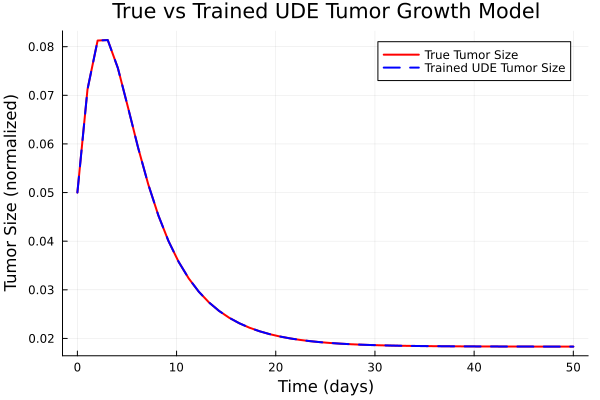

In [24]:
# 5. Evaluation and Plotting

trained_sol = solve(ude_prob, Tsit5(), p=trained_params.u, saveat=t)

plot(t, true_sol[1, :], label="True Tumor Size", linewidth=2, color=:red)
plot!(t, trained_sol[1, :], label="Trained UDE Tumor Size", linewidth=2, linestyle=:dash, color=:blue)

xlabel!("Time (days)")
ylabel!("Tumor Size (normalized)")
title!("True vs Trained UDE Tumor Growth Model")

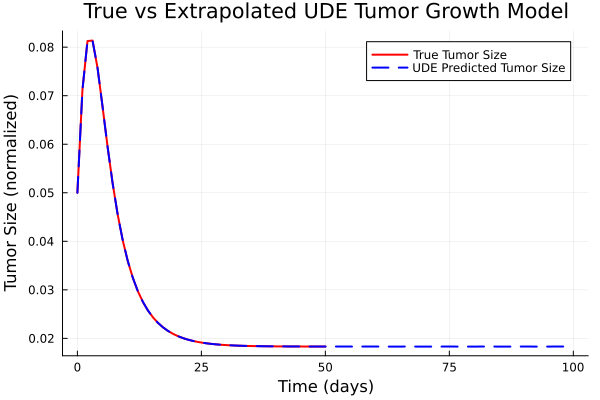

In [26]:
# 6. Extrapolation

N_days2 = 100
tspan2 = (0.0, Float64(N_days2))
t2 = range(tspan2[1], tspan2[2], length=N_days2)

ude_prob2 = ODEProblem(tumor_UDE!, u0, tspan2, p0_vec)
trained_sol2 = solve(ude_prob2, Tsit5(), p=trained_params.u, saveat=t2)

plot(t, true_sol[1, :], label="True Tumor Size", linewidth=2, color=:red)
plot!(t2, trained_sol2[1, :], label="UDE Predicted Tumor Size", linewidth=2, linestyle=:dash, color=:blue)

xlabel!("Time (days)")
ylabel!("Tumor Size (normalized)")
title!("True vs Extrapolated UDE Tumor Growth Model")